In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from typing import Callable

from observational_fear.trajectories import TrajectorySolver, TrajectoryVisulizer
from observational_fear.utils import WideLoader

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
DATA_DIR = Path(r"F:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")
save_dir = DATA_DIR / "derived" / "tradjectories"
save_dir.mkdir(exist_ok=True)

In [2]:
def get_trajectories_single(loading_kwargs, trajectory_kwargs, centerer_fac):
    traces = WideLoader(rotate=False, **loading_kwargs).traces
    trajectory_finder = TrajectorySolver(
        traces=traces, centerer=centerer_fac(), **trajectory_kwargs
    )
    return trajectory_finder


def get_trajectories_combined(
    loading_kwargs1, loading_kwargs2, trajectory_kwargs, centerer_fac
):
    traces1 = WideLoader(rotate=False, **loading_kwargs1).traces
    traces2 = WideLoader(rotate=False, **loading_kwargs2).traces
    traces = pd.concat([traces1, traces2])
    trajectory_finder = TrajectorySolver(
        traces=traces, centerer=centerer_fac(), **trajectory_kwargs
    )
    return trajectory_finder


def save_trajectories(name: str, save_dir: Path, trajectory_finder: TrajectorySolver):
    trajectory_finder.trajectories.to_csv(
        save_dir / f"Trajectories - {name} - Trajectory TimeSeries.csv"
    )
    trajectory_finder.average_trajectories.to_csv(
        save_dir / f"Trajectories - {name} - Average Trajectory TimeSeries.csv"
    )
    trajectory_finder.scree.to_csv(save_dir / f"Trajectories - {name} - Scree.csv")
    trajectory_finder.loadings.to_csv(
        save_dir / f"Trajectories - {name} - Loadings.csv"
    )


def null_average_trajectories_single(
    name, save_dir, save, n_shuffles, loading_kwargs, trajectory_kwargs, centerer_fac
):
    df_list = []
    for i in tqdm(range(n_shuffles)):
        traces = WideLoader(rotate=True, **loading_kwargs).traces
        average_trajectories = TrajectorySolver(
            traces=traces, centerer=centerer_fac(), **trajectory_kwargs
        ).average_trajectories
        df_list.append(average_trajectories.assign(shuffle=i))
    null = pd.concat(df_list).reset_index(drop=True)
    if save:
        null.to_parquet(
            save_dir / f"Null Trajectories - {name}.parquet.gzip", compression="gzip"
        )
    return null

def null_average_trajectories_combined(
    name, save_dir, save, n_shuffles, loading_kwargs1, loading_kwargs2, trajectory_kwargs, centerer_fac
):
    df_list = []
    for i in tqdm(range(n_shuffles)):
        traces1 = WideLoader(rotate=True, **loading_kwargs1).traces
        traces2 = WideLoader(rotate=True, **loading_kwargs2).traces
        traces = pd.concat([traces1, traces2])
        average_trajectories = TrajectorySolver(
            traces=traces, centerer=centerer_fac(), **trajectory_kwargs
        ).average_trajectories
        df_list.append(average_trajectories.assign(shuffle=i))
    null = pd.concat(df_list).reset_index(drop=True)
    if save:
        null.to_parquet(
            save_dir / f"Null Trajectories - {name}.parquet.gzip", compression="gzip"
        )
    return null



def plot_trajectories(
    name: str, save_dir: Path, trajectory_finder: TrajectorySolver, save=True,
):
    plotter = TrajectoryVisulizer(name=name, save=save, save_dir=save_dir)
    plotter.plot_trajectories_line(
        trajectory_finder.trajectories, hue=trajectory_finder.compare_col
    )
    plotter.plot_avg_trajectories_line(
        trajectory_finder.average_trajectories,
        compare_col=trajectory_finder.compare_col,
    )
    plotter.plot_trajectories_pc_space_2d(
        trajectory_finder.average_trajectories,
        compare_col=trajectory_finder.compare_col,
    )
    plotter.plot_trajectories_pc_space_3d(
        trajectory_finder.average_trajectories,
        compare_col=trajectory_finder.compare_col,
    )
    plotter.plot_loadings(trajectory_finder.loadings)
    plotter.plot_scree(trajectory_finder.scree)


def run_single(
    name: str,
    save_dir: Path,
    loading_kwargs: dict,
    trajectory_kwargs: dict,
    centerer_fac: Callable,
    save: bool = True,
    run_bootstrap: bool = False,
):
    trajectory_finder = get_trajectories_single(
        loading_kwargs=loading_kwargs,
        trajectory_kwargs=trajectory_kwargs,
        centerer_fac=centerer_fac,
    )
    if save:
        save_trajectories(
            name=name, save_dir=save_dir, trajectory_finder=trajectory_finder
        )
    if run_bootstrap:
        null_average_trajectories_single(
            name=name, save_dir=save_dir,
            save=save,
            n_shuffles=75,
            loading_kwargs=loading_kwargs,
            trajectory_kwargs=trajectory_kwargs,
            centerer_fac=centerer_fac,
        )
    plot_trajectories(
        name=name, save_dir=save_dir, trajectory_finder=trajectory_finder, save=save
    )
    return trajectory_finder


def run_combined(
    name: str,
    save_dir: Path,
    loading_kwargs1: dict,
    loading_kwargs2: dict,
    trajectory_kwargs: dict,
    centerer_fac: Callable,
    save: bool = True,
    run_bootstrap: bool = False,
):
    trajectory_finder = get_trajectories_combined(
        loading_kwargs1, loading_kwargs2, trajectory_kwargs, centerer_fac
    )
    if save:
        save_trajectories(
            name=name, save_dir=save_dir, trajectory_finder=trajectory_finder
        )
    if run_bootstrap:
        null_average_trajectories_combined(
            name=name, save_dir=save_dir,
            save=save,
            n_shuffles=75,
            loading_kwargs1=loading_kwargs1,
            loading_kwargs2=loading_kwargs2,
            trajectory_kwargs=trajectory_kwargs,
            centerer_fac=centerer_fac,
        )
    plot_trajectories(
        name=name, save_dir=save_dir, trajectory_finder=trajectory_finder, save=save
    )
    return trajectory_finder


  0%|          | 0/75 [00:00<?, ?it/s]

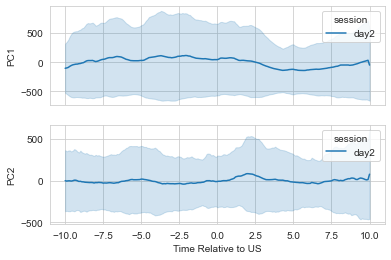

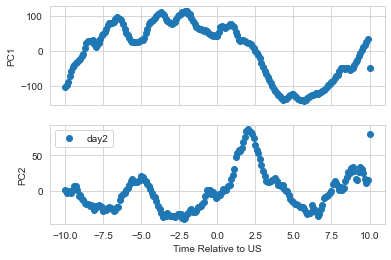

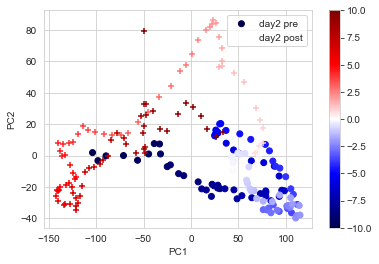

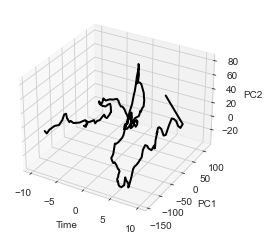

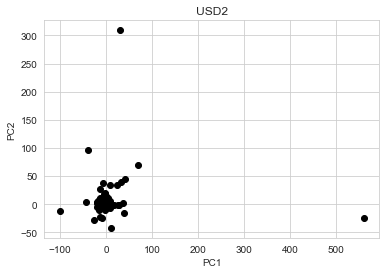

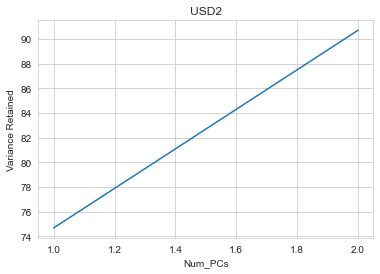

In [3]:
loading_kwargs = dict(
    data_dir=DATA_DIR,
    freeze=False,
    session="day2",
    block="US",
    t_before=10,
    t_after=10,
    coreg_only=True,
)
trajectory_kwargs = dict(method="ByTrial", compare_col="session",)
centerer_fac = lambda: StandardScaler(with_std=False)

trad = run_single(
    name="USD2",
    save_dir=save_dir,
    loading_kwargs=loading_kwargs,
    trajectory_kwargs=trajectory_kwargs,
    centerer_fac=centerer_fac,
    save=True,
    run_bootstrap=True
)

  0%|          | 0/75 [00:00<?, ?it/s]

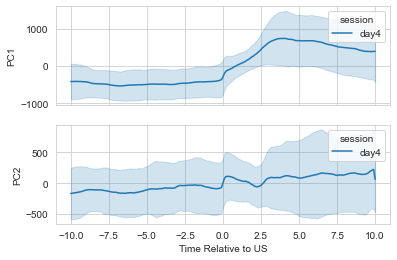

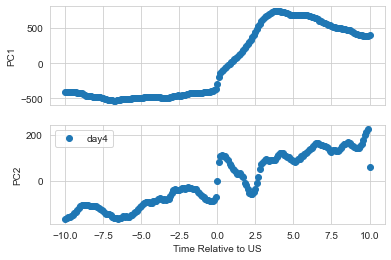

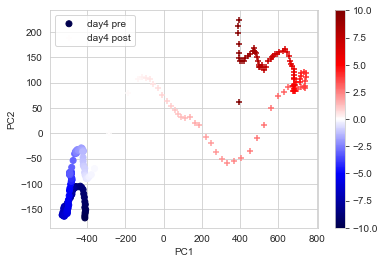

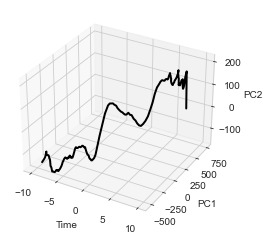

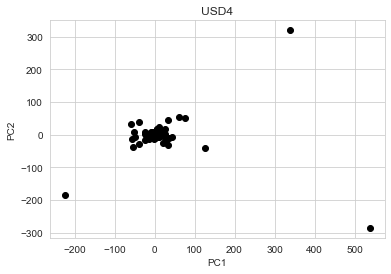

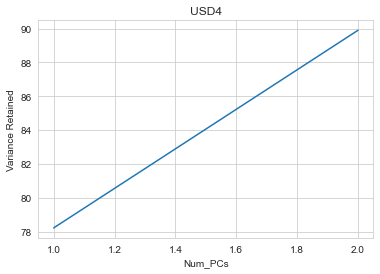

In [4]:
loading_kwargs = dict(
    data_dir=DATA_DIR,
    freeze=False,
    session="day4",
    block="US",
    t_before=10,
    t_after=10,
    coreg_only=True,
)
trajectory_kwargs = dict(method="ByTrial", compare_col="session",)
run_single(
    name="USD4",
    save_dir=save_dir,
    loading_kwargs=loading_kwargs,
    trajectory_kwargs=trajectory_kwargs,
    centerer_fac=centerer_fac,
    save=True,
    run_bootstrap=True
)

  0%|          | 0/75 [00:00<?, ?it/s]

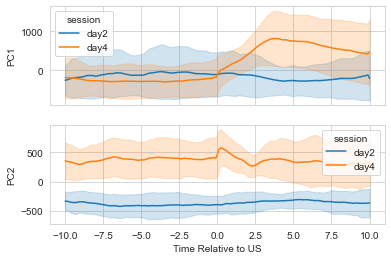

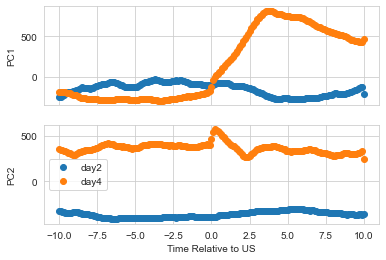

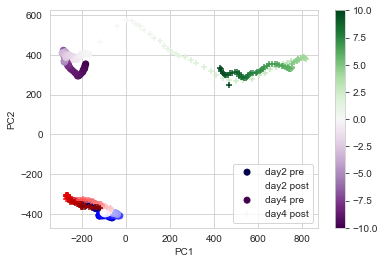

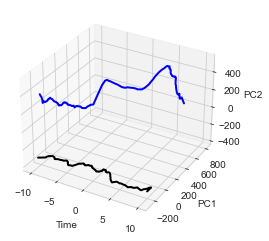

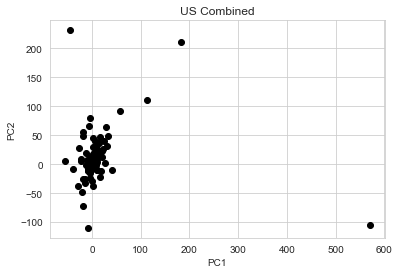

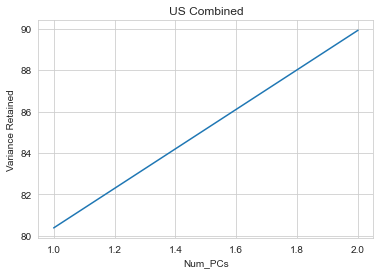

In [3]:
loading_kwargs1 = dict(
    data_dir=DATA_DIR,
    freeze=False,
    session="day2",
    block="US",
    t_before=10,
    t_after=10,
    coreg_only=True,
)
loading_kwargs2 = dict(
    data_dir=DATA_DIR,
    freeze=False,
    session="day4",
    block="US",
    t_before=10,
    t_after=10,
    coreg_only=True,
)
trajectory_kwargs = dict(method="ByTrial", compare_col="session",)
centerer_fac = lambda: StandardScaler(with_std=False)
joint = run_combined(
    name="US Combined",
    save_dir=save_dir,
    loading_kwargs1=loading_kwargs1,
    loading_kwargs2=loading_kwargs2,
    trajectory_kwargs=trajectory_kwargs,
    centerer_fac=centerer_fac,
    save=True,
    run_bootstrap=True
)

  0%|          | 0/75 [00:00<?, ?it/s]

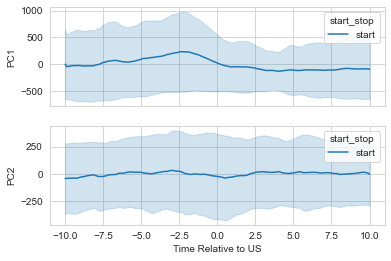

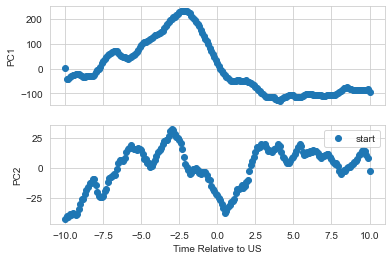

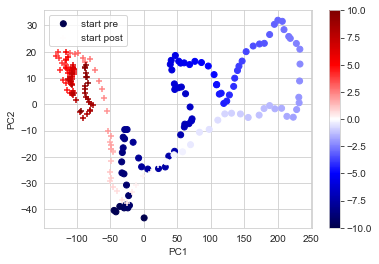

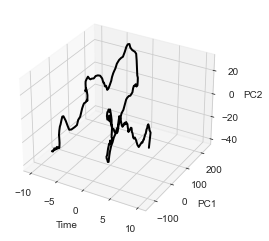

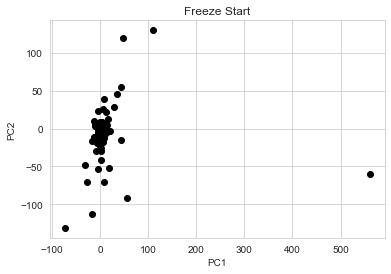

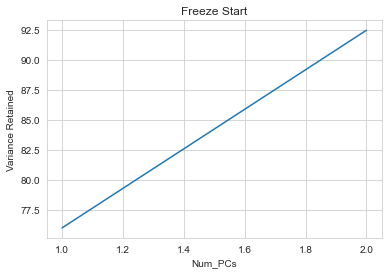

In [4]:
loading_kwargs = dict(
    data_dir=DATA_DIR,
    freeze=True,
    session="day2",
    start_stop="start",
    t_before=10,
    t_after=10,
    coreg_only=True,
)
trajectory_kwargs = dict(method="ByTrial", compare_col="start_stop",)
centerer_fac = lambda: StandardScaler(with_std=False)

run_single(
    name="Freeze Start",
    save_dir=save_dir,
    loading_kwargs=loading_kwargs,
    trajectory_kwargs=trajectory_kwargs,
    centerer_fac=centerer_fac,
    save=True,
    run_bootstrap=True,
)

  0%|          | 0/75 [00:00<?, ?it/s]

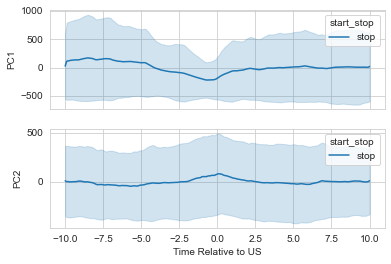

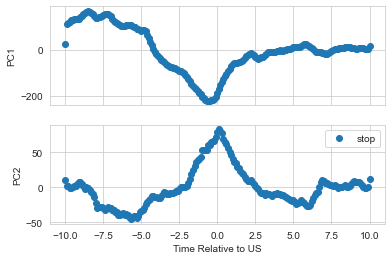

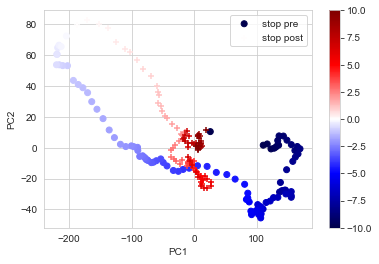

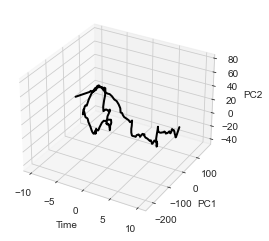

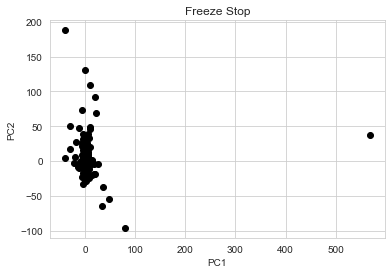

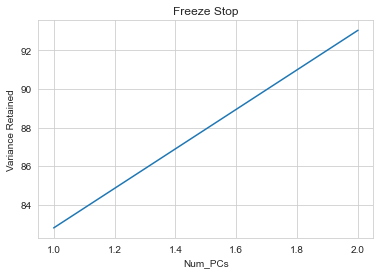

In [5]:
loading_kwargs = dict(
    data_dir=DATA_DIR,
    freeze=True,
    session="day2",
    start_stop="stop",
    t_before=10,
    t_after=10,
    coreg_only=False,
)
trajectory_kwargs = dict(method="ByTrial", compare_col="start_stop",)
centerer_fac = lambda: StandardScaler(with_std=False)

run_single(
    name="Freeze Stop",
    save_dir=save_dir,
    loading_kwargs=loading_kwargs,
    trajectory_kwargs=trajectory_kwargs,
    centerer_fac=centerer_fac,
    save=True,
    run_bootstrap=True,
)



  0%|          | 0/75 [00:00<?, ?it/s]

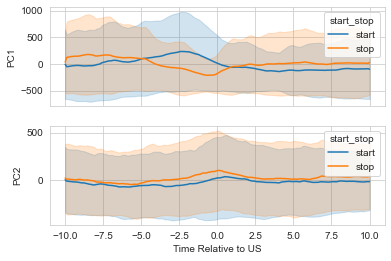

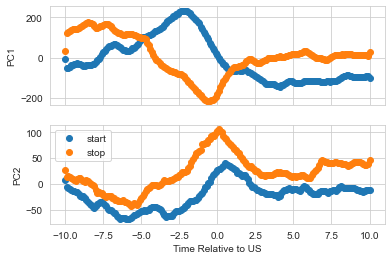

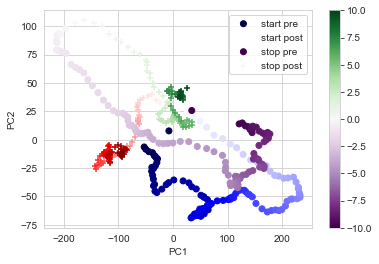

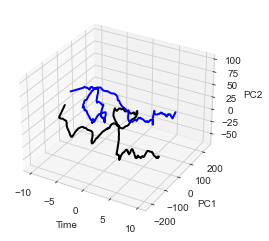

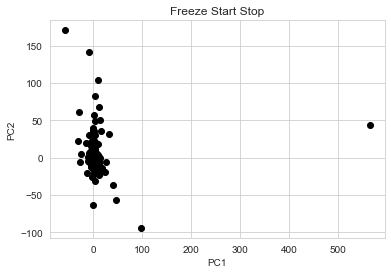

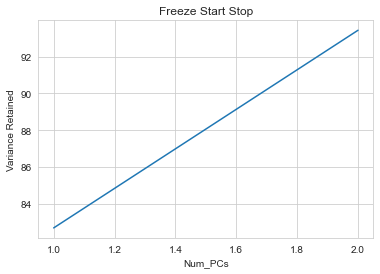

In [3]:
loading_kwargs1 = dict(
    data_dir=DATA_DIR,
    freeze=True,
    session="day2",
    start_stop="start",
    t_before=10,
    t_after=10,
    coreg_only=False,
)
loading_kwargs2 = dict(
    data_dir=DATA_DIR,
    freeze=True,
    session="day2",
    start_stop="stop",
    t_before=10,
    t_after=10,
    coreg_only=False,
)
trajectory_kwargs = dict(method="ByTrial", compare_col="start_stop",)
centerer_fac = lambda: StandardScaler(with_std=False)

joint = run_combined(
    name="Freeze Start Stop",
    save_dir=save_dir,
    loading_kwargs1=loading_kwargs1,
    loading_kwargs2=loading_kwargs2,
    trajectory_kwargs=trajectory_kwargs,
    centerer_fac=centerer_fac,
    save=True,
    run_bootstrap=True,
)